##Importing Modules

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


##Getting Datasets

In [ ]:
from pathlib import Path

data_dir = Path('/content/drive/MyDrive/Sem 6/MLEVENT/Datasets')
data_dir


PosixPath('/content/drive/MyDrive/Sem 6/MLEVENT/Datasets')

In [ ]:
image_count = len(list(data_dir.glob('*/*.png')))
print(image_count)

2168


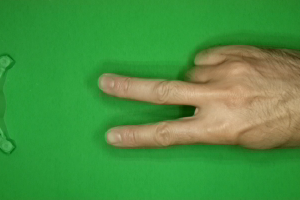

In [ ]:
scissors = list(data_dir.glob('scissors/*'))
PIL.Image.open(str(scissors[0]))

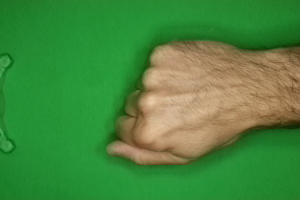

In [ ]:
rock = list(data_dir.glob('rock/*'))
PIL.Image.open(str(rock[0]))

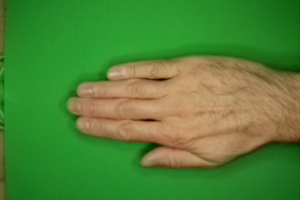

In [ ]:
paper = list(data_dir.glob('paper/*'))
PIL.Image.open(str(paper[0]))

##Load data using a Keras utility

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2168 files belonging to 3 classes.
Using 1735 files for training.


In [ ]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2168 files belonging to 3 classes.
Using 433 files for validation.


In [ ]:
class_names = train_ds.class_names
print(class_names)

['paper', 'rock', 'scissors']


##Visualize the Data

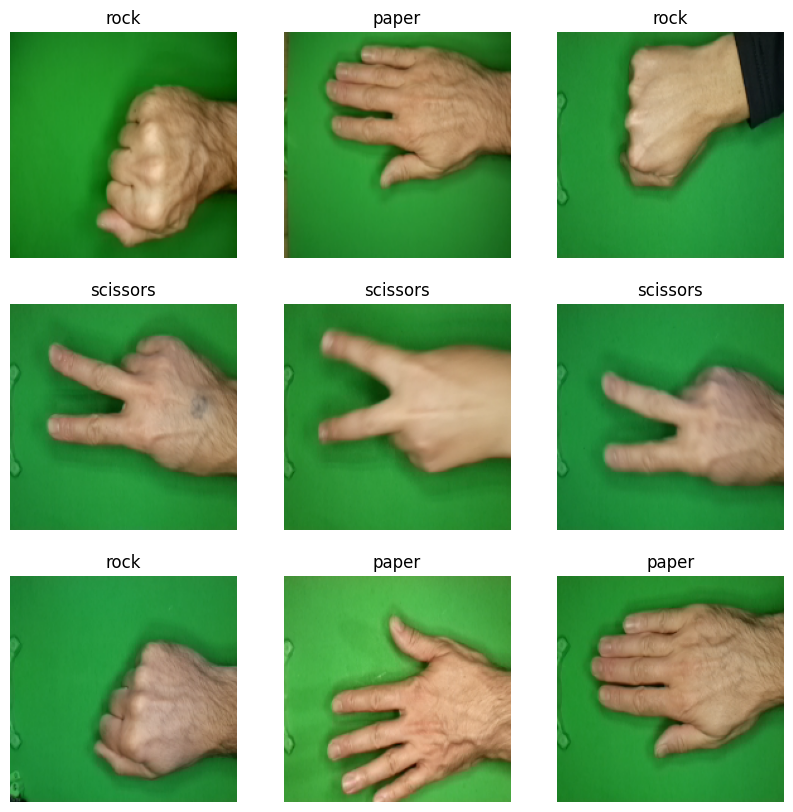

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


##Configure the dataset for performance

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

##Standardize the data

In [ ]:
normalization_layer = layers.Rescaling(1./255)

In [ ]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.00043574316 0.9267975


##A basic Keras model

In [ ]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

##Compile the model

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

##Model Summary

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 90, 90, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

##Train the Model

In [ ]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
55/55 [==============================] - 142s 3s/step - loss: 1.0074 - accuracy: 0.5522 - val_loss: 0.5195 - val_accuracy: 0.8152
Epoch 2/10
55/55 [==============================] - 63s 1s/step - loss: 0.3630 - accuracy: 0.8663 - val_loss: 0.2697 - val_accuracy: 0.9076
Epoch 3/10
55/55 [==============================] - 62s 1s/step - loss: 0.1523 - accuracy: 0.9510 - val_loss: 0.1062 - val_accuracy: 0.9654
Epoch 4/10
55/55 [==============================] - 62s 1s/step - loss: 0.0814 - accuracy: 0.9758 - val_loss: 0.1474 - val_accuracy: 0.9353
Epoch 5/10
55/55 [==============================] - 64s 1s/step - loss: 0.0430 - accuracy: 0.9862 - val_loss: 0.0854 - val_accuracy: 0.9815
Epoch 6/10
55/55 [==============================] - 66s 1s/step - loss: 0.0249 - accuracy: 0.9914 - val_loss: 0.1122 - val_accuracy: 0.9723
Epoch 7/10
55/55 [==============================] - 61s 1s/step - loss: 0.0268 - accuracy: 0.9902 - val_loss: 0.1161 - val_accuracy: 0.9746
Epoch 8/10
55/55 [=

##Visualizing training results

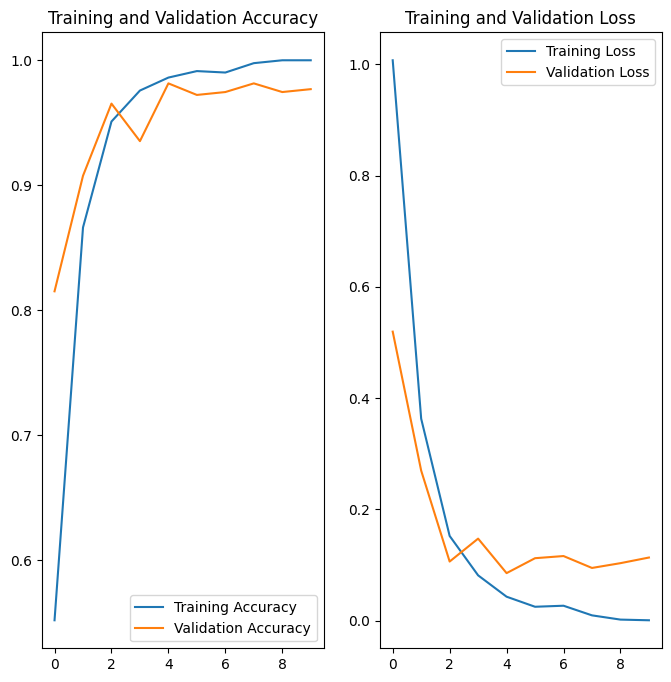

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()